Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
from collections import Counter
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [111]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2025-01-14 21:59:45.379780: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


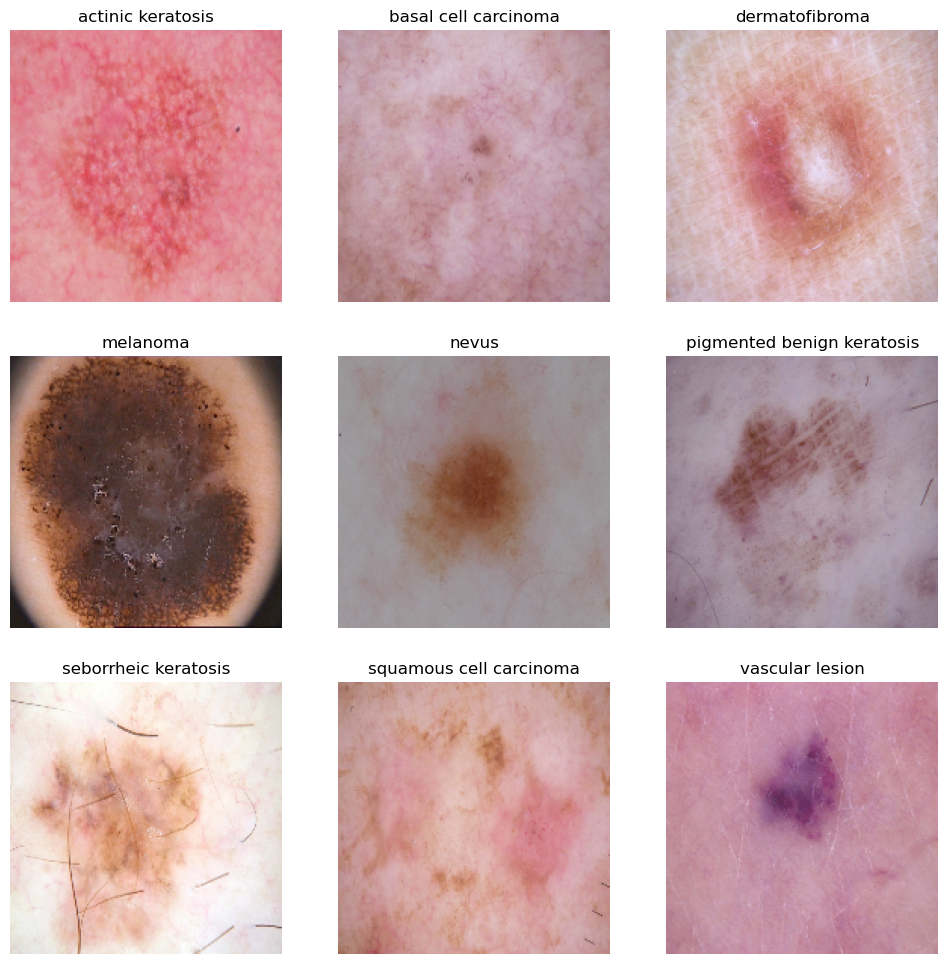

In [18]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(2):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        class_images = images[labels == i]
        if tf.reduce_sum(tf.cast(labels == i, tf.int32)) > 0:
            plt.imshow(class_images[0].numpy().astype("uint8"))
            plt.title(class_names[i])
            plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
### Your code goes here
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.1763 - loss: 2.3361 - val_accuracy: 0.2528 - val_loss: 2.0155
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.2800 - loss: 1.9476 - val_accuracy: 0.3714 - val_loss: 1.7675
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.3672 - loss: 1.7944 - val_accuracy: 0.4206 - val_loss: 1.6626
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4561 - loss: 1.6384 - val_accuracy: 0.4922 - val_loss: 1.4991
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.4642 - loss: 1.5593 - val_accuracy: 0.4340 - val_loss: 1.6034
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4552 - loss: 1.5682 - val_accuracy: 0.5078 - val_loss: 1.4543
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.4838 - loss: 1.4766 - val_accuracy: 0.5078 - val_loss: 1.4356
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.5046 - loss: 1.4205 - val_accu

### Visualizing training results

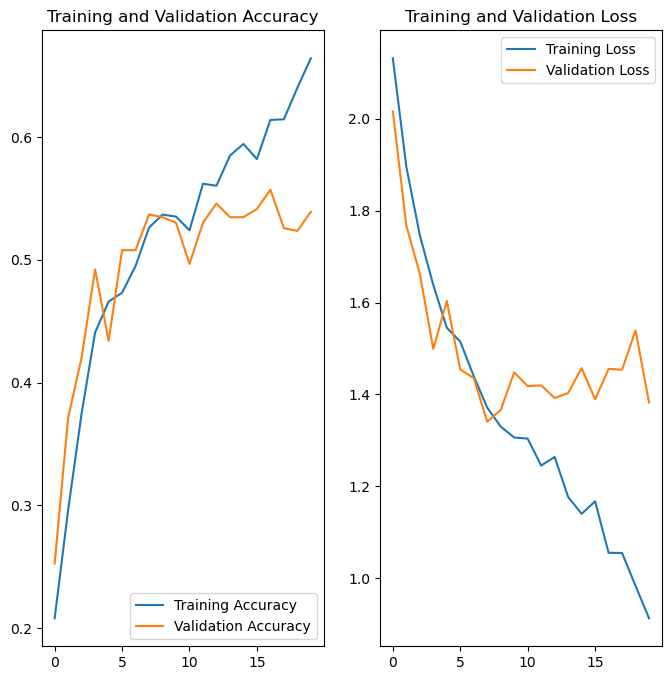

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. #### Training vs Validation Accuracy:


- The training accuracy (blue line) continues to increase steadily, reaching about 65%
- The validation accuracy (orange line) plateaus around 50-55% and shows fluctuations
- The growing gap between training and validation accuracy is a classic sign of overfitting


2. #### Training vs Validation Loss:


- The training loss (blue line) continues to decrease steadily
- The validation loss (orange line) initially decreases but then plateaus and slightly increases
- The divergence between training and validation loss curves further confirms overfitting


3. #### Specific Indicators of Overfitting:


- The model performs increasingly better on the training data while not improving on validation data
- Around epoch 10, the curves begin to diverge significantly
- The model is learning patterns specific to the training data that don't generalize well to new data

In [35]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes herea

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [36]:
augmented_train_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

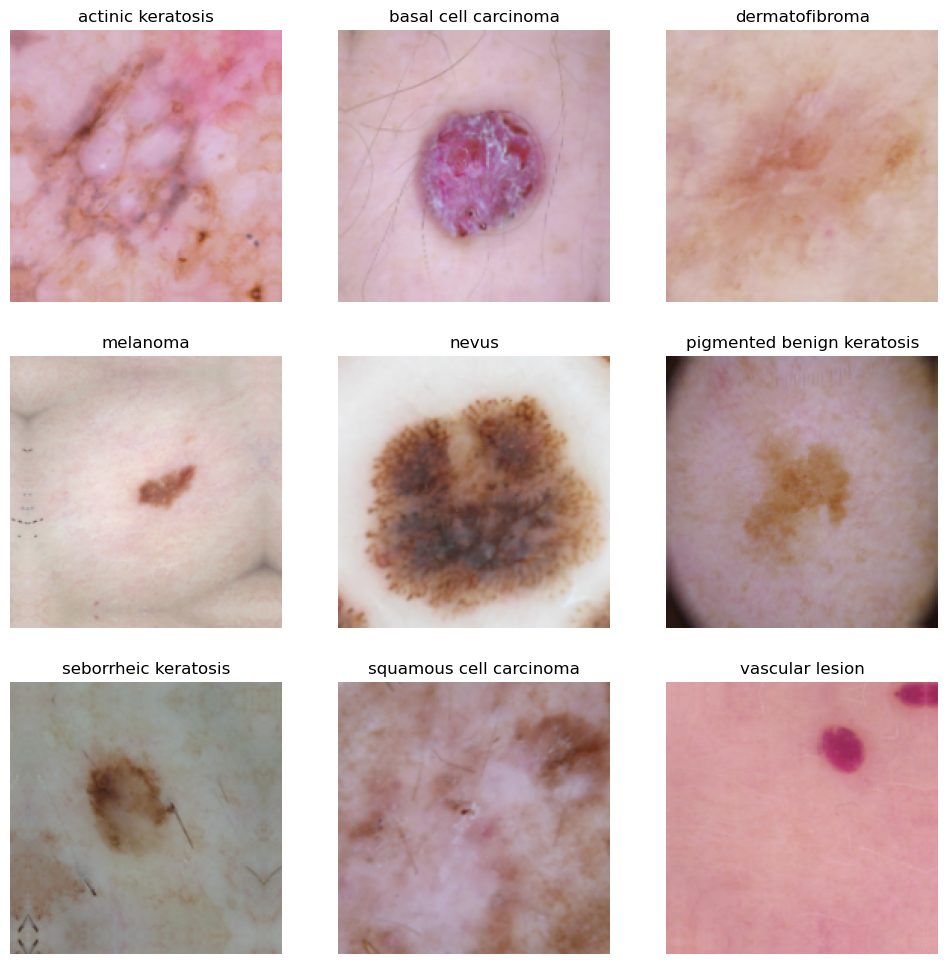

In [37]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in augmented_train_dataset.take(2):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        class_images = images[labels == i]
        if tf.reduce_sum(tf.cast(labels == i, tf.int32)) > 0:
            plt.imshow(class_images[0].numpy().astype("uint8"))
            plt.title(class_names[i])
            plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [39]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes rehe
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])



### Compiling the model

In [41]:
## Your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [44]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model.fit(
  augmented_train_dataset,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.1933 - loss: 2.1915 - val_accuracy: 0.4273 - val_loss: 1.7997
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3702 - loss: 1.8069 - val_accuracy: 0.3870 - val_loss: 1.7258
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3557 - loss: 1.8665 - val_accuracy: 0.4318 - val_loss: 1.6946
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3983 - loss: 1.7090 - val_accuracy: 0.4385 - val_loss: 1.6116
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4151 - loss: 1.6278 - val_accuracy: 0.4877 - val_loss: 1.5416
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4328 - loss: 1.6316 - val_accuracy: 0.4922 - val_loss: 1.6925
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4366 - loss: 1.6004 - val_accuracy: 0.5056 - val_loss: 1.4466
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4752 - loss: 1.5225 - val_accu

### Visualizing the results

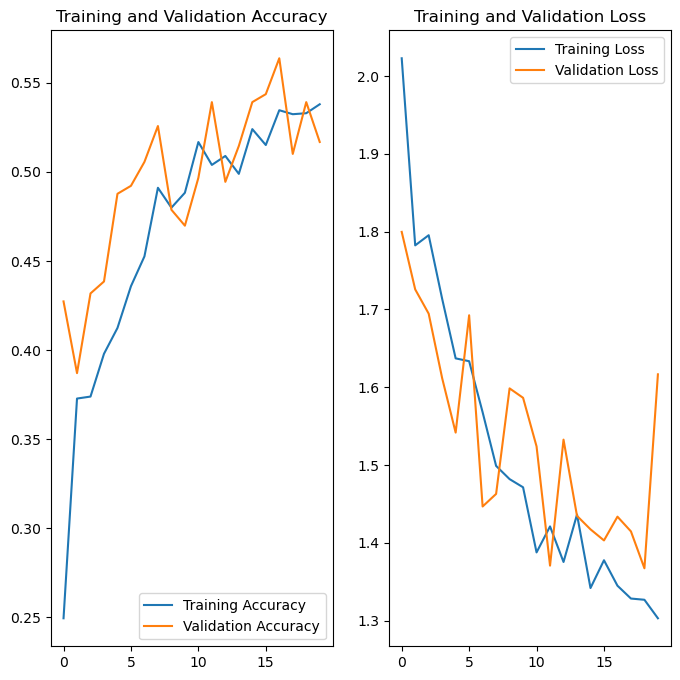

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Observations for the Current Model Run:

1. #### Training vs Validation Accuracy:


- Both training (blue) and validation (orange) accuracy curves follow similar trajectories
- They increase gradually and stay close to each other, reaching around 52-55%
- The curves show healthy fluctuations but maintain similar overall trends


2. #### Training vs Validation Loss:


- Both loss curves decrease consistently
- The training and validation losses remain relatively close to each other
- Some natural fluctuations exist but no concerning divergence


3. #### Improvements over Previous Model:


- Much better generalization: Unlike Model 1, there's no significant gap between training and validation metrics
- More stable learning: The curves are smoother and show less erratic behavior
- No clear signs of overfitting: The training accuracy isn't climbing far above validation accuracy
- Both accuracy curves end around 53%, compared to Model 1 where training accuracy reached 65% while validation stayed at 55%

This model appears to be neither overfitting nor underfitting, showing a balanced learning pattern. However, there might be room for improvement since:

> The final accuracy (~53%) is relatively low, suggesting the model might benefit from Additional training time

> Overall, this is a significant improvement over Model 1 in terms of learning stability and generalization, even though the absolute performance might still need enhancement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [113]:
## Your code goes here.
# Path to training dataset
train_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"

# ImageDataGenerator instance
datagen = ImageDataGenerator()
train_data = datagen.flow_from_directory(train_path)

class_labels = train_data.classes

# Count occurrences of each class
class_distribution = Counter(class_labels)

# Map the counts to the class names
class_names_ref = {v: k for k, v in train_data.class_indices.items()}
class_distribution_named = {class_names_ref[k]: v for k, v in class_distribution.items()}

print("Class Distribution:", class_distribution_named)

Found 6739 images belonging to 9 classes.
Class Distribution: {'actinic keratosis': 614, 'basal cell carcinoma': 876, 'dermatofibroma': 595, 'melanoma': 938, 'nevus': 857, 'pigmented benign keratosis': 962, 'seborrheic keratosis': 577, 'squamous cell carcinoma': 681, 'vascular lesion': 639}


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
> #### seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
> #### pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [55]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31FEF7D40>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 95 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31CF0D2B0>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0


Initialised with 357 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x359ABB200>: 100%|


Initialised with 462 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x35D0DF2F0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31885C2F0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31CE50350>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000549.jpg_6a1a8339-601b-4a5c-8a57-c5da59d93a0f.jpg',
 '/Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_a2e2f200-2440-4c4d-9ffe-74cbe1dba7b0.jpg',
 '/Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010080.jpg_75aa8c89-48bd-4816-9665-58155343c2f1.jpg',
 '/Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001102.jpg_f42b873b-6a0a-4f62-8f78-6f7e45bdd7d9.jpg',
 '/Users/ankitsalian/Developer/Machine_Learning_Notes/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging Collaboration/

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [63]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2))

In [65]:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)

#### **Todo:** Create a training dataset

In [79]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [83]:
## your code goes here
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [85]:
### Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [89]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 209ms/step - accuracy: 0.1887 - loss: 2.1631 - val_accuracy: 0.4061 - val_loss: 1.7105
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.3584 - loss: 1.6909 - val_accuracy: 0.4462 - val_loss: 1.4512
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.4289 - loss: 1.4957 - val_accuracy: 0.4581 - val_loss: 1.4017
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.4828 - loss: 1.3982 - val_accuracy: 0.5330 - val_loss: 1.2576
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.5003 - loss: 1.3010 - val_accuracy: 0.5850 - val_loss: 1.1725
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.5415 - loss: 1.2234 - val_accuracy: 0.6169 - val_loss: 1.0699
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.5650 - loss: 1.1665 - val_accuracy: 0.6295 - val_loss: 0.9913
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.5798 - loss: 1

#### **Todo:**  Visualize the model results

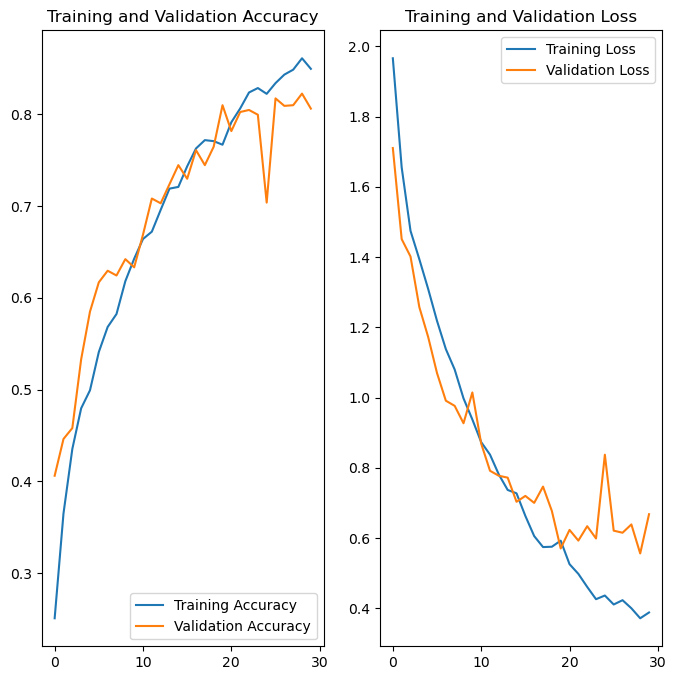

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Observations for the Current Model Run:

1. #### Training vs Validation Accuracy:


- Both curves show strong upward trajectories, reaching much higher accuracies (~80-85%)
- The curves track each other closely until around epoch 20
- After epoch 20, there's a slight divergence with training accuracy moving slightly higher than validation accuracy
- There's one notable validation accuracy drop around epoch 25, but it recovers quickly


2. #### Training vs Validation Loss:


- Both loss curves show consistent decrease initially
- After epoch 15, training loss (blue) continues to decrease while validation loss (orange) plateaus and shows more fluctuation
- The growing gap between training and validation loss in later epochs suggests the beginning of overfitting


3. #### Improvements over Previous Models:


- Much higher accuracy achieved (80-85% vs ~53% in Model 2)
- Better learning stability in the first 20 epochs
- Stronger overall performance and learning capacity
- More training epochs allowed (30 vs ~18 in previous models)


4. #### Areas of Concern:


- Mild overfitting appears to begin after epoch 20, as evidenced by:

> - Diverging loss curves
> - Training accuracy continuing to climb while validation accuracy plateaus
> - Increased validation accuracy volatility

This model represents the best performance of the three, with significantly higher accuracy and better learning characteristics, despite the mild overfitting in later epochs. The improvements in model architecture or hyperparameters have clearly yielded better results.